# Imports

In [343]:
import json, random
import sys, statistics

In [344]:
from market import Market, Produto

In [345]:
from PIL import Image
from IPython.display import display
import plotly.graph_objects as go
from collections import Counter

# Static Values

In [346]:
CART: dict = {
    'Altura': 65,
    'Largura': 50,
    'Comprimento': 80,
    'PesoMaximo': 460*1000
}

CART['Capacidade'] = CART['Altura'] * CART['Largura'] * CART['Comprimento']

CART

{'Altura': 65,
 'Largura': 50,
 'Comprimento': 80,
 'PesoMaximo': 460000,
 'Capacidade': 260000}

In [ ]:
MAX_MONEY: float = 1000.0
MAX_ITEMS: int = 25
MAX_CARTS: int = 100
MAX_GENERATIONS: int = 1200
BESTS: int = 10

# Funções

In [348]:
m: Market = Market(r"C:\Users\Arklok\Documents\Projetos\gen-algorithm\data\produtos.csv")

In [349]:
def mosaic(cart: list[Produto], row_quantity: int = 5, image_size: tuple[int, int] = (300, 300)) -> None:
    images: list[Image] = [product.show(popup=False).resize(image_size) for product in cart]
    
    mosaic_size: tuple[int, int] = (image_size[0]*row_quantity, image_size[1]*((len(images)//row_quantity)+1))
    
    mosaic: Image = Image.new('RGB', mosaic_size)
    
    for i, image in enumerate(images):
        mosaic.paste(image, (image_size[0]*(i%row_quantity), image_size[1]*(i//row_quantity)))
    
    display(mosaic) 

In [350]:
def plot_generations(data):
    # Extraindo as iterações e os valores
    iterations = list(data.keys())
    max_values = [data[i]['max'] for i in iterations]
    min_values = [data[i]['min'] for i in iterations]
    avg_values = [data[i]['med'] for i in iterations]

    # Criando o gráfico
    fig = go.Figure()

    # Adicionando as linhas para cada tipo
    fig.add_trace(go.Scatter(x=iterations, y=max_values, mode='lines+markers', name='Max'))
    fig.add_trace(go.Scatter(x=iterations, y=min_values, mode='lines+markers', name='Min'))
    fig.add_trace(go.Scatter(x=iterations, y=avg_values, mode='lines+markers', name='Medio'))

    # Adicionando título e rótulos
    fig.update_layout(title='Gráfico de Gerações',
                      xaxis_title='Iteração',
                      yaxis_title='Valores',
                      yaxis_type='log',  # Define o eixo y como logarítmico
                      template='plotly')

    # Exibindo o gráfico
    fig.show()

In [351]:
def calculate_regression(data: dict, last: int = 100) -> float:
    if len(data) < last:
        return float("inf")
    
    else:
        values: list = list(data.values())[-last:]
        return statistics.stdev([value.get('min') for value in values])

In [352]:
def calculate_volum(x: float, y: float, z: float) -> float:
    return x * y * z

# Genético

### Geração de Indivíduos

In [353]:
def gerar_carrinho(tamanho: int = globals()['MAX_ITEMS']) -> list[Produto]:
    compra = []

    while len(compra) < tamanho:
        item: Produto = m.random()
        compra.append(item)
        
    return compra

In [354]:
c: list[Produto] = gerar_carrinho()
c

[<Produto(id=568595>,
 <Produto(id=181460>,
 <Produto(id=223912>,
 <Produto(id=459752>,
 <Produto(id=409753>,
 <Produto(id=24186>,
 <Produto(id=611160>,
 <Produto(id=459782>,
 <Produto(id=120342>,
 <Produto(id=1309018>,
 <Produto(id=1624541>,
 <Produto(id=55835>,
 <Produto(id=70008>,
 <Produto(id=478712>,
 <Produto(id=282731>,
 <Produto(id=314717>,
 <Produto(id=1615748>,
 <Produto(id=459752>,
 <Produto(id=1566833>,
 <Produto(id=672256>]

### Geração de População Inicial

In [355]:
def gerar_populacao(tamanho: int = globals()['MAX_CARTS']) -> list[list[Produto]]:
    return [gerar_carrinho() for _ in range(tamanho)]

In [356]:
p: list[list[Produto]] = gerar_populacao()
p

[[<Produto(id=1377278>,
  <Produto(id=180330>,
  <Produto(id=457550>,
  <Produto(id=102476>,
  <Produto(id=53711>,
  <Produto(id=69432>,
  <Produto(id=26699>,
  <Produto(id=568591>,
  <Produto(id=56627>,
  <Produto(id=223563>,
  <Produto(id=406015>,
  <Produto(id=133870>,
  <Produto(id=634933>,
  <Produto(id=168623>,
  <Produto(id=1568668>,
  <Produto(id=1376291>,
  <Produto(id=178400>,
  <Produto(id=65885>,
  <Produto(id=1616575>,
  <Produto(id=1616576>],
 [<Produto(id=37886>,
  <Produto(id=1440449>,
  <Produto(id=1615315>,
  <Produto(id=1616281>,
  <Produto(id=365395>,
  <Produto(id=68750>,
  <Produto(id=324197>,
  <Produto(id=278801>,
  <Produto(id=1624118>,
  <Produto(id=1618988>,
  <Produto(id=146522>,
  <Produto(id=465035>,
  <Produto(id=499770>,
  <Produto(id=470253>,
  <Produto(id=5728>,
  <Produto(id=438223>,
  <Produto(id=1613588>,
  <Produto(id=479199>,
  <Produto(id=1377629>,
  <Produto(id=347653>],
 [<Produto(id=1616483>,
  <Produto(id=1441479>,
  <Produto(id=327734>,
  <P

### Avaliação

In [358]:
def avaliar(individuo: list[Produto]) -> float:
    valor_total: float = sum(produto.price for produto in individuo)
    peso_total: float = sum(produto.weight for produto in individuo)
    volume_total: float = sum(calculate_volum(produto.height, produto.width, produto.depth) for produto in individuo)
    categorias_unicas: set = len(set(produto.category for produto in individuo))
    repeticoes: int = sum(individuo.count(produto) for produto in individuo)

    # Penalidades
    penalidade_peso = max(0, peso_total - globals()['CART']['PesoMaximo'])
    penalidade_volume = max(0, volume_total - globals()['CART']['Capacidade'])
    penalidade_repeticao = max(0, repeticoes)*5
    
    # Penalidade se o valor total for baixo em relação ao número de produtos
    penalidade_valor_baixo = 0
    if individuo:
        media_valor = valor_total / len(individuo)
        penalidade_valor_baixo = sum(1 for produto in individuo if produto.price < media_valor)

    # Bônus
    bonus_diversidade = categorias_unicas **2# Bônus por categoria

    # Cálculo da função de fitness
    fitness = (
        (penalidade_peso + penalidade_volume + penalidade_valor_baixo + penalidade_repeticao) + (valor_total + bonus_diversidade)
    )
    return fitness**2  # Mantém a elevação ao quadrado


In [359]:
n: float = avaliar(c)
n

1001500.5625

In [360]:
def mapear_notas(populacao: list[list[Produto]], order: str = 'asc') -> dict[float, list[Produto]]:
    notas: dict = {avaliar(individuo): individuo for individuo in populacao}
    
    if order == 'asc':
        return dict(sorted(notas.items()))
    
    else:
        return dict(sorted(notas.items(), reverse=True))

In [361]:
nt: dict[float, list[Produto]] = mapear_notas(p)
nt

{197811.4576: [<Produto(id=12263>,
  <Produto(id=461592>,
  <Produto(id=9498>,
  <Produto(id=470253>,
  <Produto(id=35189>,
  <Produto(id=323696>,
  <Produto(id=100533>,
  <Produto(id=339051>,
  <Produto(id=318904>,
  <Produto(id=431874>,
  <Produto(id=170983>,
  <Produto(id=282114>,
  <Produto(id=71969>,
  <Produto(id=29497>,
  <Produto(id=80070>,
  <Produto(id=231381>,
  <Produto(id=1616281>,
  <Produto(id=321063>,
  <Produto(id=13204>,
  <Produto(id=292195>],
 256562.51039999997: [<Produto(id=168387>,
  <Produto(id=12263>,
  <Produto(id=1566833>,
  <Produto(id=407427>,
  <Produto(id=450286>,
  <Produto(id=324113>,
  <Produto(id=54940>,
  <Produto(id=687151>,
  <Produto(id=431865>,
  <Produto(id=409355>,
  <Produto(id=113943>,
  <Produto(id=821656>,
  <Produto(id=95963>,
  <Produto(id=86987>,
  <Produto(id=330821>,
  <Produto(id=1618531>,
  <Produto(id=53711>,
  <Produto(id=1600697>,
  <Produto(id=337821>,
  <Produto(id=471126>],
 290531.7801: [<Produto(id=161459>,
  <Produto(id=1538

### Seleção

In [362]:
def torneio(populacao: list[list[Produto]]) -> list[list[Produto]]:
    vencedores: list[list[Produto] | None] = []
    
    while len(vencedores) < 2:
        competidor_1: list[Produto] = random.choice(populacao)
        competidor_2: list[Produto] = random.choice(populacao)
                
        # Seleção do melhor individuo:
        if avaliar(competidor_1) < avaliar(competidor_2):
            vencedor: list[Produto] = competidor_1
        
        elif avaliar(competidor_1) > avaliar(competidor_2):
            vencedor: list[Produto] = competidor_2
            
        else:
            vencedor: list[Produto] = random.choice([competidor_1, competidor_2])
            
        if vencedor not in vencedores:
            vencedores.append(vencedor)
    
    return vencedores

In [363]:
v1: list[list[Produto]] = torneio(p)
v1

[[<Produto(id=160404>,
  <Produto(id=140452>,
  <Produto(id=34660>,
  <Produto(id=1616575>,
  <Produto(id=868>,
  <Produto(id=604625>,
  <Produto(id=142418>,
  <Produto(id=160404>,
  <Produto(id=343037>,
  <Produto(id=22595>,
  <Produto(id=1471541>,
  <Produto(id=584620>,
  <Produto(id=145358>,
  <Produto(id=1613312>,
  <Produto(id=148184>,
  <Produto(id=284066>,
  <Produto(id=326265>,
  <Produto(id=245703>,
  <Produto(id=697133>,
  <Produto(id=1461878>],
 [<Produto(id=1616943>,
  <Produto(id=278801>,
  <Produto(id=1566833>,
  <Produto(id=1628298>,
  <Produto(id=1591032>,
  <Produto(id=707>,
  <Produto(id=467613>,
  <Produto(id=804255>,
  <Produto(id=604605>,
  <Produto(id=379837>,
  <Produto(id=468138>,
  <Produto(id=442242>,
  <Produto(id=530631>,
  <Produto(id=19468>,
  <Produto(id=120342>,
  <Produto(id=379881>,
  <Produto(id=95706>,
  <Produto(id=55835>,
  <Produto(id=1600697>,
  <Produto(id=162383>]]

In [364]:
def roleta_viciada(populacao: list[list[Produto]]) -> list[list[Produto]]:
    fitness_list: list[float] = [1 / avaliar(individuo) for individuo in populacao]
    total_fitness: float = sum(fitness_list)
    probabilities: list[float] = [fitness / total_fitness for fitness in fitness_list]
    
    vencedores: list[list[Produto]] = random.choices(populacao, weights=probabilities, k=2)
    
    return vencedores

In [365]:
v2: list[list[Produto]] = roleta_viciada(p)
v2

[[<Produto(id=113943>,
  <Produto(id=672257>,
  <Produto(id=760243>,
  <Produto(id=1377629>,
  <Produto(id=170800>,
  <Produto(id=332651>,
  <Produto(id=421705>,
  <Produto(id=168387>,
  <Produto(id=174511>,
  <Produto(id=30116>,
  <Produto(id=271505>,
  <Produto(id=1440412>,
  <Produto(id=585414>,
  <Produto(id=175398>,
  <Produto(id=86987>,
  <Produto(id=421225>,
  <Produto(id=289978>,
  <Produto(id=13918>,
  <Produto(id=38628>,
  <Produto(id=1613314>],
 [<Produto(id=1614082>,
  <Produto(id=604625>,
  <Produto(id=788816>,
  <Produto(id=439797>,
  <Produto(id=170712>,
  <Produto(id=1616578>,
  <Produto(id=318906>,
  <Produto(id=568623>,
  <Produto(id=427413>,
  <Produto(id=25181>,
  <Produto(id=1115358>,
  <Produto(id=1606864>,
  <Produto(id=160404>,
  <Produto(id=169113>,
  <Produto(id=427861>,
  <Produto(id=284066>,
  <Produto(id=164065>,
  <Produto(id=788816>,
  <Produto(id=461591>,
  <Produto(id=343039>]]

In [366]:
def eugenia(populacao: list[list[Produto]], order: str = 'asc') -> list[list[Produto]]:
    notas: dict[float, list[Produto]] = mapear_notas(populacao, order)
    melhores: list[list[Produto]] = list(notas.values())[:globals()['BESTS']]
    
    return melhores

In [367]:
e: list[list[Produto]] = eugenia(p)
e

[[<Produto(id=12263>,
  <Produto(id=461592>,
  <Produto(id=9498>,
  <Produto(id=470253>,
  <Produto(id=35189>,
  <Produto(id=323696>,
  <Produto(id=100533>,
  <Produto(id=339051>,
  <Produto(id=318904>,
  <Produto(id=431874>,
  <Produto(id=170983>,
  <Produto(id=282114>,
  <Produto(id=71969>,
  <Produto(id=29497>,
  <Produto(id=80070>,
  <Produto(id=231381>,
  <Produto(id=1616281>,
  <Produto(id=321063>,
  <Produto(id=13204>,
  <Produto(id=292195>],
 [<Produto(id=168387>,
  <Produto(id=12263>,
  <Produto(id=1566833>,
  <Produto(id=407427>,
  <Produto(id=450286>,
  <Produto(id=324113>,
  <Produto(id=54940>,
  <Produto(id=687151>,
  <Produto(id=431865>,
  <Produto(id=409355>,
  <Produto(id=113943>,
  <Produto(id=821656>,
  <Produto(id=95963>,
  <Produto(id=86987>,
  <Produto(id=330821>,
  <Produto(id=1618531>,
  <Produto(id=53711>,
  <Produto(id=1600697>,
  <Produto(id=337821>,
  <Produto(id=471126>],
 [<Produto(id=161459>,
  <Produto(id=1538480>,
  <Produto(id=1440416>,
  <Produto(id=14

### Crossover e Mutação

In [368]:
def cruzamento(pais: list[list[Produto]], chance: float = 0.8) -> list[list[Produto]]:
    pai_1: list[Produto] = pais[0]
    pai_2: list[Produto] = pais[1]

    probabilidade: float = round(random.uniform(0, 1), 2)

    if probabilidade < chance:
        pos: int = random.randint(0, len(pai_1))

        filho_1: list[Produto] = pai_1[:pos] + pai_2[pos:]
        filho_2: list[Produto] = pai_2[:pos] + pai_1[pos:]

        return [filho_1, filho_2]

    else:
        return [pai_1, pai_2]

In [369]:
f: list[list[Produto]] = cruzamento(v1)
f

[[<Produto(id=160404>,
  <Produto(id=278801>,
  <Produto(id=1566833>,
  <Produto(id=1628298>,
  <Produto(id=1591032>,
  <Produto(id=707>,
  <Produto(id=467613>,
  <Produto(id=804255>,
  <Produto(id=604605>,
  <Produto(id=379837>,
  <Produto(id=468138>,
  <Produto(id=442242>,
  <Produto(id=530631>,
  <Produto(id=19468>,
  <Produto(id=120342>,
  <Produto(id=379881>,
  <Produto(id=95706>,
  <Produto(id=55835>,
  <Produto(id=1600697>,
  <Produto(id=162383>],
 [<Produto(id=1616943>,
  <Produto(id=140452>,
  <Produto(id=34660>,
  <Produto(id=1616575>,
  <Produto(id=868>,
  <Produto(id=604625>,
  <Produto(id=142418>,
  <Produto(id=160404>,
  <Produto(id=343037>,
  <Produto(id=22595>,
  <Produto(id=1471541>,
  <Produto(id=584620>,
  <Produto(id=145358>,
  <Produto(id=1613312>,
  <Produto(id=148184>,
  <Produto(id=284066>,
  <Produto(id=326265>,
  <Produto(id=245703>,
  <Produto(id=697133>,
  <Produto(id=1461878>]]

In [370]:
def mutar(populacao: list[list[Produto]], chance = 0.05) -> list[list[Produto]]: 
    mutados: list[list[Produto]] = []

    for individuo in populacao:
        for pos, alelo in enumerate(individuo):
            mutacao: float = round(random.uniform(0, 1), 3)

            if mutacao < chance:
                novo_gene: str = m.random(ignore_case=[alelo,]) 
                individuo: str = individuo[:pos] + [novo_gene] + individuo[pos+1:]

        mutados.append(individuo)
    
    return mutados

In [371]:
mt: list[list[Produto]] = mutar(f)
mt

[[<Produto(id=160404>,
  <Produto(id=278801>,
  <Produto(id=461591>,
  <Produto(id=1628298>,
  <Produto(id=1591032>,
  <Produto(id=707>,
  <Produto(id=467613>,
  <Produto(id=804255>,
  <Produto(id=604605>,
  <Produto(id=379837>,
  <Produto(id=468138>,
  <Produto(id=442242>,
  <Produto(id=530631>,
  <Produto(id=19468>,
  <Produto(id=120342>,
  <Produto(id=379881>,
  <Produto(id=95706>,
  <Produto(id=55835>,
  <Produto(id=1600697>,
  <Produto(id=162383>],
 [<Produto(id=1616943>,
  <Produto(id=140452>,
  <Produto(id=34660>,
  <Produto(id=1616575>,
  <Produto(id=868>,
  <Produto(id=604625>,
  <Produto(id=142418>,
  <Produto(id=160404>,
  <Produto(id=343037>,
  <Produto(id=434731>,
  <Produto(id=1471541>,
  <Produto(id=584620>,
  <Produto(id=145358>,
  <Produto(id=1613312>,
  <Produto(id=148184>,
  <Produto(id=284066>,
  <Produto(id=326265>,
  <Produto(id=245703>,
  <Produto(id=697133>,
  <Produto(id=1461878>]]

# Execução Principal

In [372]:
relatorio: dict[dict[str: float]] = {}

In [373]:
if __name__ == '__main__':
    i: int = 0
    
    populacao_inicial: list[list[Produto]] = gerar_populacao()
    populacao_atual: list[list[Produto]] = populacao_inicial.copy()
    
    while i < MAX_GENERATIONS and calculate_regression(relatorio) >= 1:
        i+=1

        geracao: list[list[Produto]] = []

        while len(geracao) < (MAX_CARTS - BESTS):
            notas: dict[float, list[Produto]] = mapear_notas(populacao_atual)
            
            pais: list[list[Produto]] = roleta_viciada(populacao_atual)
            filhos: list[list[Produto]] = mutar(cruzamento(pais))
            geracao.extend(filhos)
            
        geracao.extend(eugenia(populacao_atual))
        
        relatorio[i]: dict = {'max': max(notas.keys()), 'min': min(notas.keys()), 'med': statistics.median(notas.keys())}
        
        populacao_atual: list[list[Produto]] = geracao.copy()
        
        sys.stdout.write(f'\rGeração: {i}\n')

Geração: 1
Geração: 2
Geração: 3
Geração: 4
Geração: 5
Geração: 6
Geração: 7
Geração: 8
Geração: 9
Geração: 10
Geração: 11
Geração: 12
Geração: 13
Geração: 14
Geração: 15
Geração: 16
Geração: 17
Geração: 18
Geração: 19
Geração: 20
Geração: 21
Geração: 22
Geração: 23
Geração: 24
Geração: 25
Geração: 26
Geração: 27
Geração: 28
Geração: 29
Geração: 30
Geração: 31
Geração: 32
Geração: 33
Geração: 34
Geração: 35
Geração: 36
Geração: 37
Geração: 38
Geração: 39
Geração: 40
Geração: 41
Geração: 42
Geração: 43
Geração: 44
Geração: 45
Geração: 46
Geração: 47
Geração: 48
Geração: 49
Geração: 50
Geração: 51
Geração: 52
Geração: 53
Geração: 54
Geração: 55
Geração: 56
Geração: 57
Geração: 58
Geração: 59
Geração: 60
Geração: 61
Geração: 62
Geração: 63
Geração: 64
Geração: 65
Geração: 66
Geração: 67
Geração: 68
Geração: 69
Geração: 70
Geração: 71
Geração: 72
Geração: 73
Geração: 74
Geração: 75
Geração: 76
Geração: 77
Geração: 78
Geração: 79
Geração: 80
Geração: 81
Geração: 82
Geração: 83
Geração: 84
G

In [374]:
for gen, data in relatorio.items():
    print(f'Geração: {gen} - {data}')

Geração: 1 - {'max': 1276832.2009, 'min': 157299.4921, 'med': 572501.65345}
Geração: 2 - {'max': 1301949.4608999998, 'min': 157299.4921, 'med': 450140.75885}
Geração: 3 - {'max': 1126845.9409, 'min': 151313.2201, 'med': 344451.61}
Geração: 4 - {'max': 757282.8484, 'min': 139584.4321, 'med': 299602.99210000003}
Geração: 5 - {'max': 801186.1081000001, 'min': 139584.4321, 'med': 282906.9721}
Geração: 6 - {'max': 604568.4515999999, 'min': 139584.4321, 'med': 244394.24320000003}
Geração: 7 - {'max': 618424.96, 'min': 132736.34889999998, 'med': 246528.4301}
Geração: 8 - {'max': 534229.4280999999, 'min': 130906.4761, 'med': 201942.8069}
Geração: 9 - {'max': 424673.7889000001, 'min': 117827.4276, 'med': 194777.61245000002}
Geração: 10 - {'max': 399133.3329, 'min': 115484.42889999998, 'med': 177005.31840000002}
Geração: 11 - {'max': 427519.8225, 'min': 115484.42889999998, 'med': 189274.63525}
Geração: 12 - {'max': 551306.25, 'min': 111816.6721, 'med': 175552.6201}
Geração: 13 - {'max': 366751.3

In [375]:
plot_generations(relatorio)

In [376]:
best_individual: list[Produto] = eugenia(populacao_atual)[0]
print(
    f"Geração: {i}\nMelhor nota: {avaliar(best_individual)}\nValor: {sum([item.price for item in best_individual])}\nCarrinho: {best_individual}\n"
)

Geração: 719
Melhor nota: 27782.222400000002
Valor: 56.68
Carrinho: [<Produto(id=365990>, <Produto(id=384522>, <Produto(id=327734>, <Produto(id=670165>, <Produto(id=431868>, <Produto(id=12628>, <Produto(id=407910>, <Produto(id=334191>, <Produto(id=190826>, <Produto(id=1471540>, <Produto(id=182374>, <Produto(id=1433060>, <Produto(id=1616960>, <Produto(id=379835>, <Produto(id=117446>, <Produto(id=379833>, <Produto(id=418507>, <Produto(id=327625>, <Produto(id=379836>, <Produto(id=1614978>]



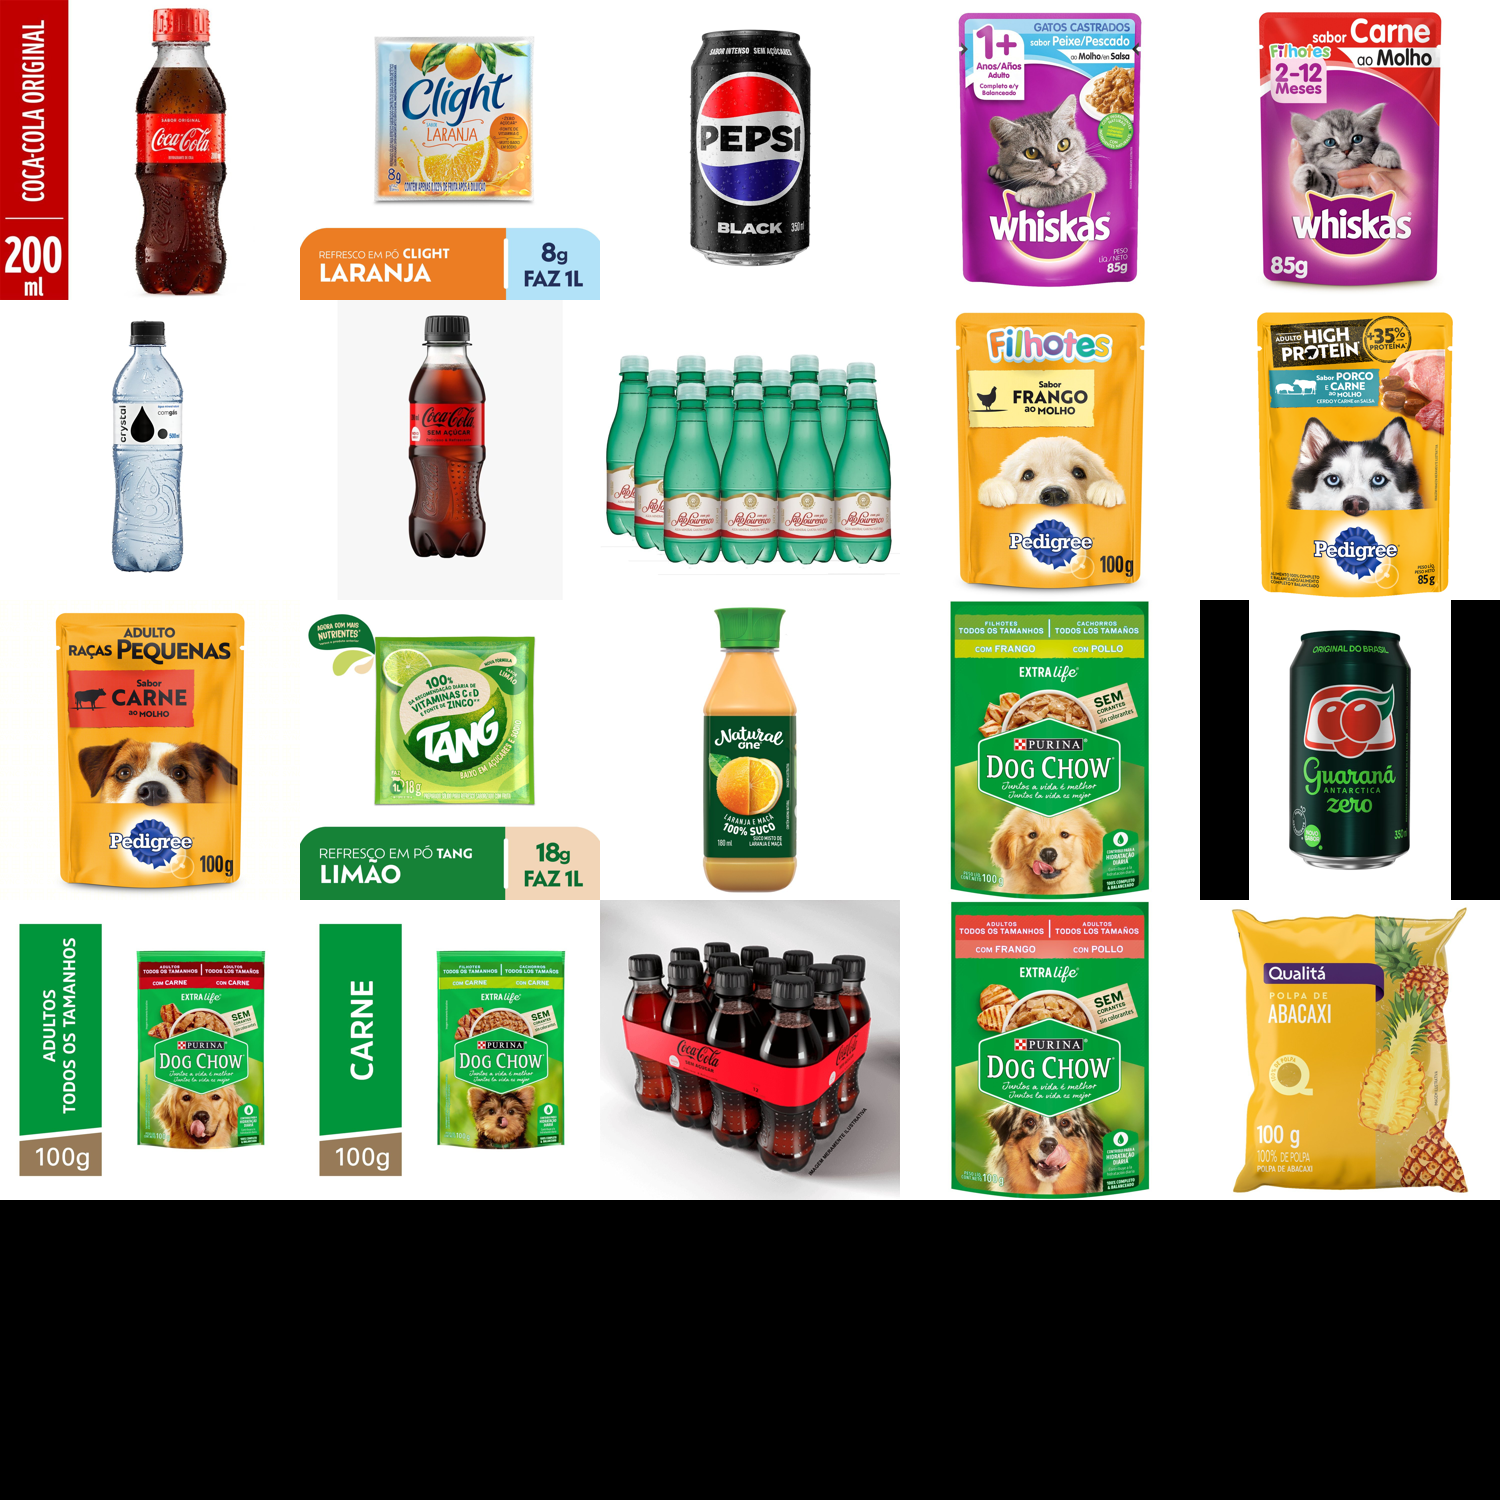

In [377]:
mosaic(best_individual)